# **Introduction**

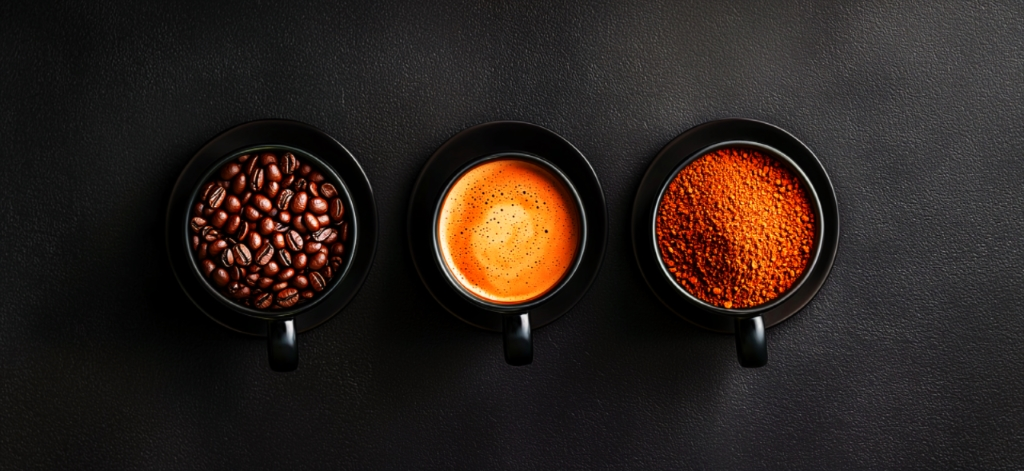

**Project Overview**

This project aims to analyze a coffee sales dataset to understand sales patterns and customer behavior. It also explores different machine learning models to predict daily sales and uses Facebook Prophet for time series forecasting.

**Key objectives are:**
1. Perform Exploratory Data Analysis (EDA) to understand trends across time (hourly, daily, monthly), coffee types, and payment methods.

2. Preprocess data for machine learning modeling.

3. Create and evaluate various regression models (LightGBM, Random Forest, XGBoost) to predict daily sales.

4. Use Facebook Prophet to predict daily sales for the next 14 days.

5. Visualize key findings and model performance.

**Let's get to know the [dataset](https://www.kaggle.com/datasets/ihelon/coffee-sales):**

- `date`: Date of the transaction.
- `datetime`: Exact date and time of the transaction.
- `cash_type`: Indicates whether the payment was made by 'card' or 'cash'.
- `card`: Anonymized card identifier (usually contains non-empty values ​​for 'card' transactions).
- `money`: Monetary value of the transaction.
- `coffee_name`: Name of the coffee product purchased.

# **Import And Install Necessary Libraries**

In [1]:
# !pip install lightgbm
# !pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from prophet import Prophet
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

# **Load the Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/coffee-sales/index_1.csv")

In [4]:
df

date                 datetime cash_type                 card  \
0     2024-03-01  2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   
1     2024-03-01  2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   
2     2024-03-01  2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   
3     2024-03-01  2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   
4     2024-03-01  2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   
...          ...                      ...       ...                  ...   
3631  2025-03-23  2025-03-23 10:34:54.894      card  ANON-0000-0000-1158   
3632  2025-03-23  2025-03-23 14:43:37.362      card  ANON-0000-0000-1315   
3633  2025-03-23  2025-03-23 14:44:16.864      card  ANON-0000-0000-1315   
3634  2025-03-23  2025-03-23 15:47:28.723      card  ANON-0000-0000-1316   
3635  2025-03-23  2025-03-23 18:11:38.635      card  ANON-0000-0000-1275   

      money    coffee_name  
0     38.70          Latte  
1     38.70  Hot Chocolate  
2     38.70  Hot Chocolate  
3     28.90      Americano  
4     38.70          Latte  
...     ...            ...  
3631  35.76     Cappuccino  
3632  35.76          Cocoa  
3633  35.76          Cocoa  
3634  25.96      Americano  
3635  35.76          Latte  

[3636 rows x 6 columns]

# **Understand And Organize the Dataset**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   datetime     3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   money        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB


In [6]:
df.shape

(3636, 6)

In [7]:
df.isnull().sum()

date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64

In [8]:
df.describe()

money
count  3636.000000
mean     31.746859
std       4.919926
min      18.120000
25%      27.920000
50%      32.820000
75%      35.760000
max      40.000000

In [9]:
df['coffee_name'].unique()

array(['Latte', 'Hot Chocolate', 'Americano', 'Americano with Milk',
       'Cocoa', 'Cortado', 'Espresso', 'Cappuccino'], dtype=object)

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   object        
 1   datetime     3636 non-null   datetime64[ns]
 2   cash_type    3636 non-null   object        
 3   card         3547 non-null   object        
 4   money        3636 non-null   float64       
 5   coffee_name  3636 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 170.6+ KB


# **EDA (Exploratory Data Analysis)**

## **Coffee Sales Money per Hour of Day**

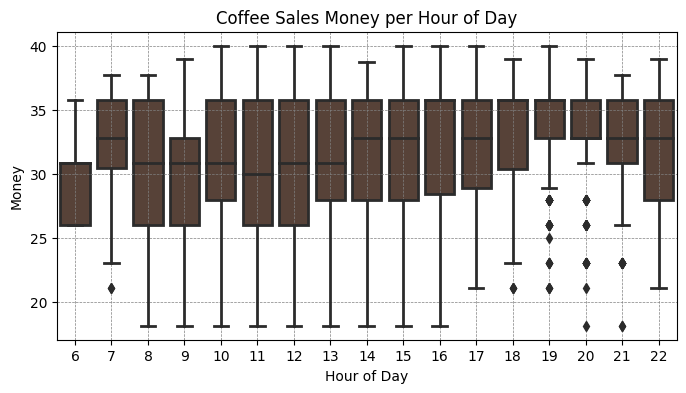

In [12]:
df['hour'] = df['datetime'].dt.hour

plt.figure(figsize=(8, 4))
sns.boxplot(x='hour', y='money', data=df, color="#5C4033", linewidth=2)
plt.title('Coffee Sales Money per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Money')
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")

plt.show()

## **Hourly Coffee Sales**

In [13]:
hourly_coffee_sales = df.groupby(df['datetime'].dt.hour)['money'].sum()

In [14]:
hourly_coffee_sales

datetime
6       149.40
7      2940.02
8      7017.88
9      7429.28
10    10994.52
11     8849.10
12     7668.62
13     7108.76
14     7265.80
15     7789.02
16     9221.60
17     7925.00
18     7235.60
19     7966.96
20     5656.92
21     6465.94
22     3747.16
Name: money, dtype: float64

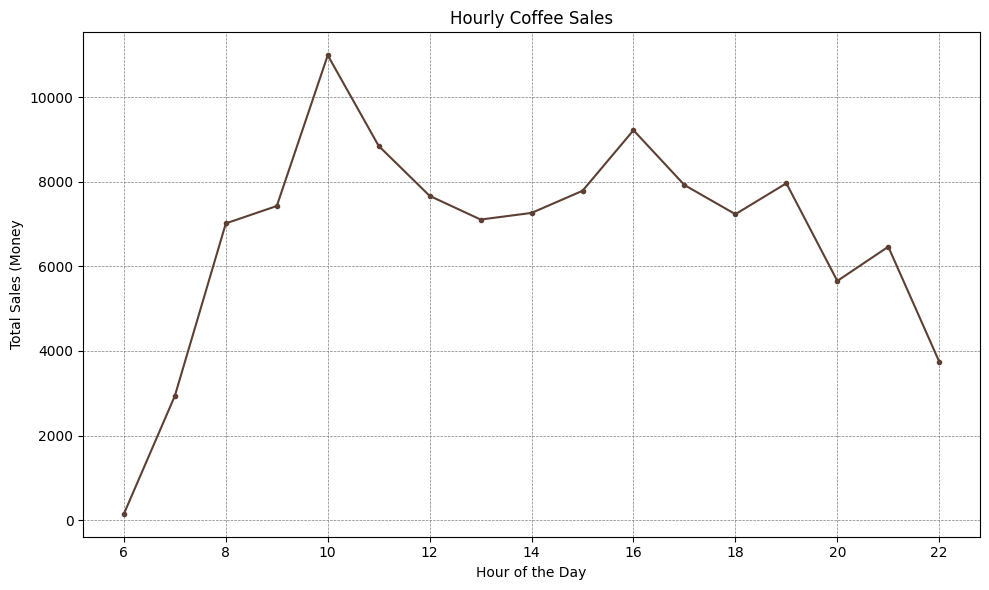

In [15]:
plt.figure(figsize=(10, 6))
hourly_coffee_sales.plot(kind='line', marker='.', linestyle='-', color="#5C4033")
plt.title('Hourly Coffee Sales')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Sales (Money')
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()

## **Sales Revenue by Hour**

In [16]:
df["hourly_total_sales"] = df.groupby(["hour", "coffee_name"])["money"].transform("sum")

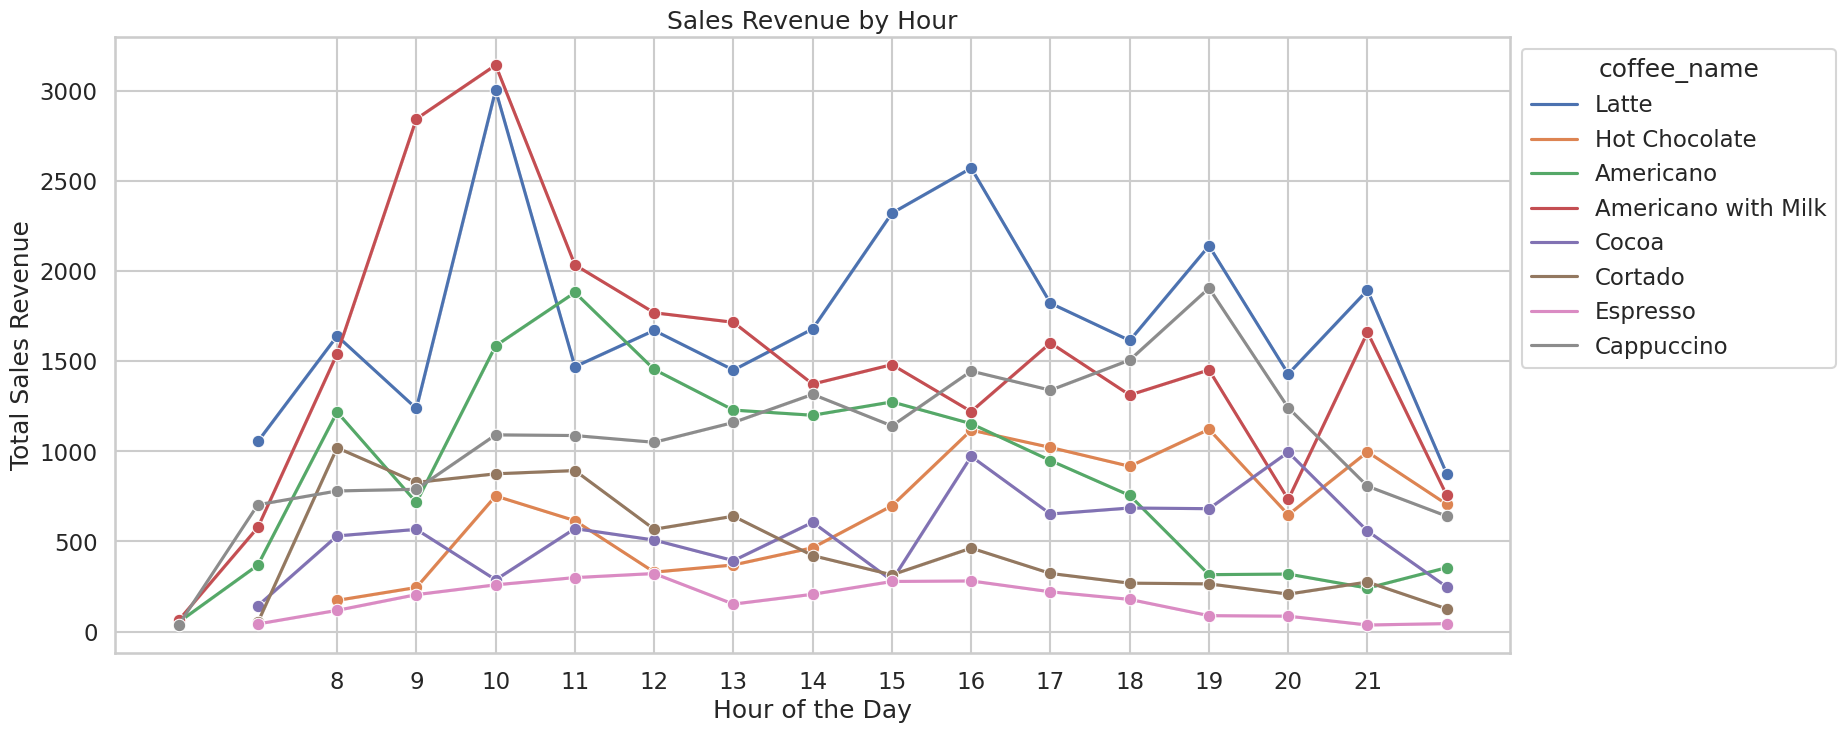

In [17]:
plt.figure(figsize=(18, 8))

sns.set(style="whitegrid")
sns.set_context("talk")

ax = sns.lineplot(data=df, x="hour", y="hourly_total_sales", hue="coffee_name", marker="o")

plt.title("Sales Revenue by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Sales Revenue")
plt.xticks(range(8, 22))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


## **Daily Sales for the Year**

In [18]:
daily_sales = df.groupby(df['datetime'].dt.date )['money'].sum()

In [19]:
daily_sales

datetime
2024-03-01    396.30
2024-03-02    228.10
2024-03-03    349.10
2024-03-04    135.20
2024-03-05    338.50
               ...  
2025-03-19    623.56
2025-03-20    597.60
2025-03-21    636.80
2025-03-22    365.42
2025-03-23    204.76
Name: money, Length: 381, dtype: float64

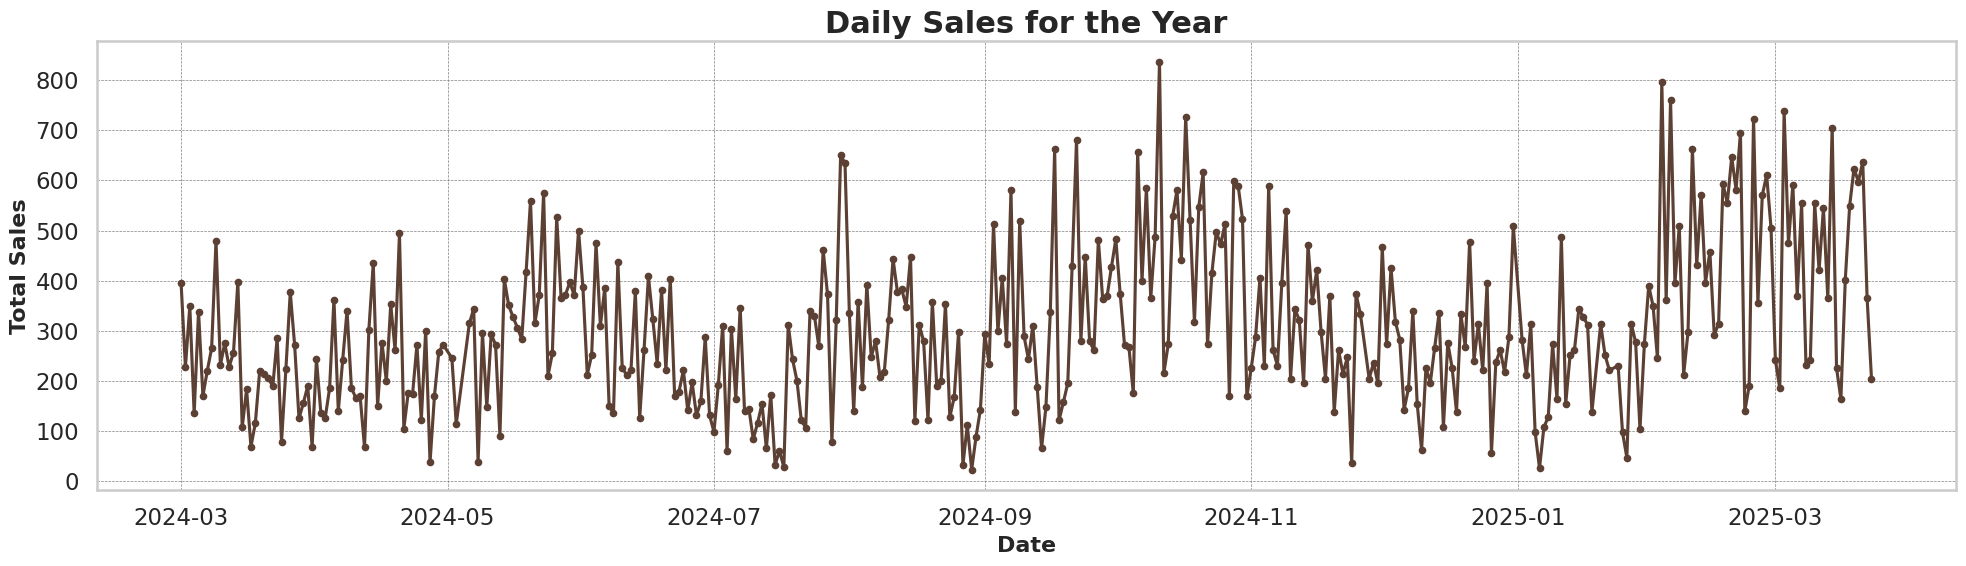

In [20]:
plt.figure(figsize=(20, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='.', linestyle='-', color = "#5C4033")
plt.title('Daily Sales for the Year', fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()

## **Coffee Sales Count by Hour of the Day and Day of the Week**

In [21]:
df['Day of Week'] = df['datetime'].dt.day_name()

daily_hourly_summary = df.groupby(['Day of Week', 'hour'])\
    .agg({'money': ['count', 'sum', 'mean']}).reset_index()
daily_hourly_summary.head()

Day of Week hour money                    
                   count      sum       mean
0      Friday    6     3    87.68  29.226667
1      Friday    7    18   575.08  31.948889
2      Friday    8    49  1480.78  30.220000
3      Friday    9    52  1532.50  29.471154
4      Friday   10    46  1451.84  31.561739

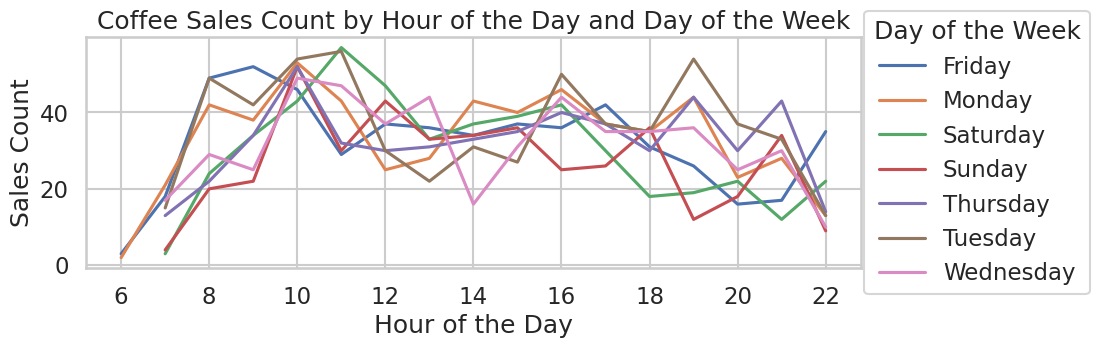

In [22]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'count'), hue='Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Count')
plt.title('Coffee Sales Count by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

## **Coffee Sales Sum by Hour of the Day and Day of the Week**

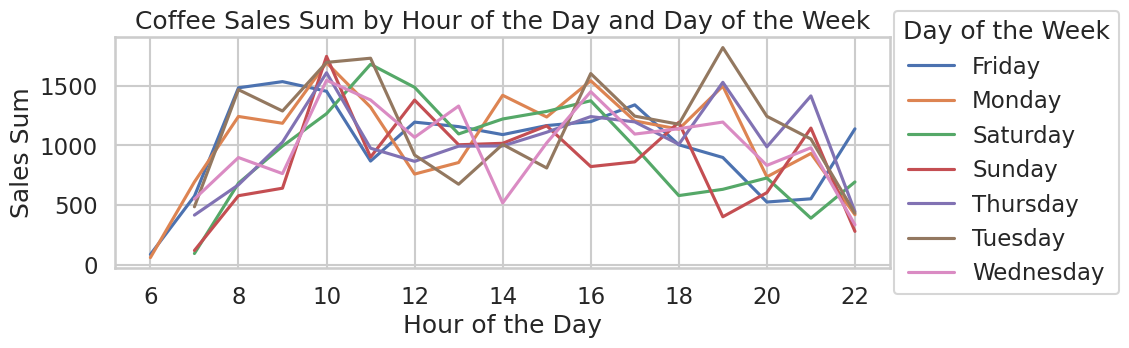

In [23]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'sum'), hue='Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Sum')
plt.title('Coffee Sales Sum by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

## **Coffee Sales Average by Hour of the Day and Day of the Week**

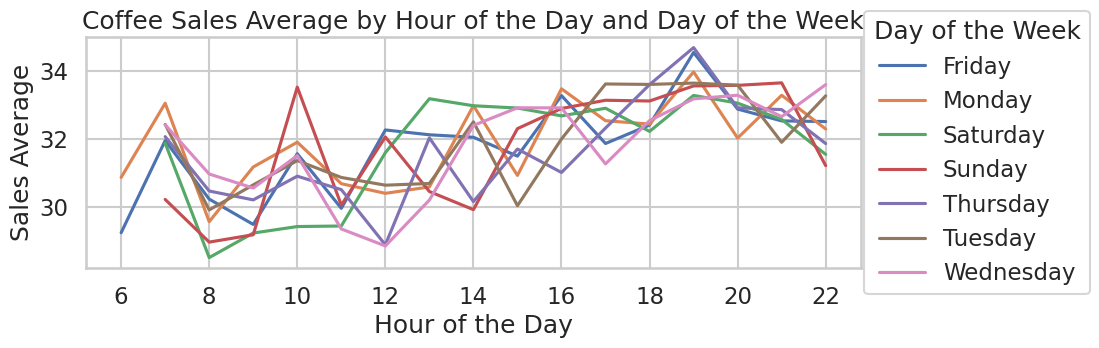

In [24]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'mean'), hue='Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Average')
plt.title('Coffee Sales Average by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

## **Average Coffee Sales per Month**

In [25]:
df['month'] = df['datetime'].dt.to_period('M')

In [26]:
df['month']

0       2024-03
1       2024-03
2       2024-03
3       2024-03
4       2024-03
         ...   
3631    2025-03
3632    2025-03
3633    2025-03
3634    2025-03
3635    2025-03
Name: month, Length: 3636, dtype: period[M]

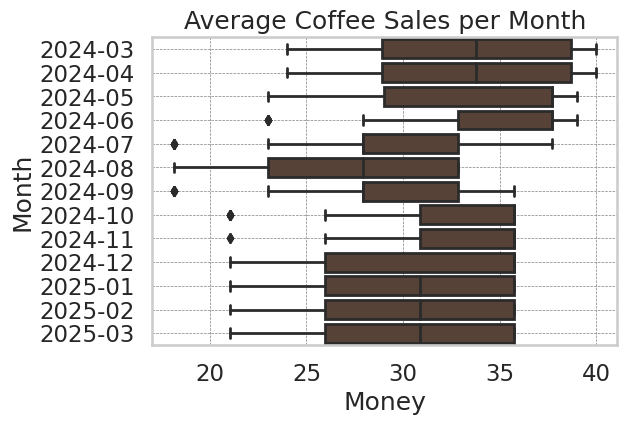

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(x='money', y='month', data=df, color="#5C4033", linewidth=2)
plt.title('Average Coffee Sales per Month')
plt.xlabel('Money')
plt.ylabel('Month')
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")

plt.show()

## **Total Coffee Sales per Month**

In [28]:
monthly_coffee_sales = df.groupby('month')['money'].aggregate('sum')
monthly_coffee_sales = pd.DataFrame(monthly_coffee_sales).reset_index()

In [29]:
monthly_coffee_sales

month     money
0   2024-03   7050.20
1   2024-04   6720.56
2   2024-05   9063.42
3   2024-06   7758.76
4   2024-07   6915.94
5   2024-08   7613.84
6   2024-09   9988.64
7   2024-10  13891.16
8   2024-11   8590.54
9   2024-12   8237.74
10  2025-01   6398.86
11  2025-02  13215.48
12  2025-03   9986.44

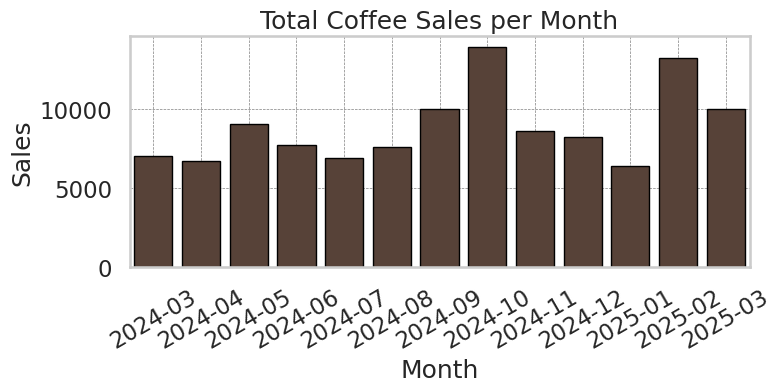

In [30]:
plt.figure(figsize=(8, 3))
sns.barplot(data=monthly_coffee_sales, x='month', y='money', color="#5C4033", edgecolor='black', linewidth=1);
plt.title('Total Coffee Sales per Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.show()

## **Monthly Sales Revenue**

In [31]:
df["day"] = pd.to_datetime(df["date"]).dt.date
df["daily_sales"] = df.groupby(["day", "coffee_name"])["money"].transform("sum")

In [32]:
df["monthly_sales"] = df.groupby(["month", "coffee_name"])["money"].transform("sum")
df["month_str"] = df["month"].dt.strftime('%Y-%m')

In [33]:
df["monthly_sales"]

0       1874.50
1        854.00
2        854.00
3       1044.80
4       1874.50
         ...   
3631    1537.68
3632    1072.80
3633    1072.80
3634    2647.92
3635    2038.32
Name: monthly_sales, Length: 3636, dtype: float64

In [34]:
df["month_str"]

0       2024-03
1       2024-03
2       2024-03
3       2024-03
4       2024-03
         ...   
3631    2025-03
3632    2025-03
3633    2025-03
3634    2025-03
3635    2025-03
Name: month_str, Length: 3636, dtype: object

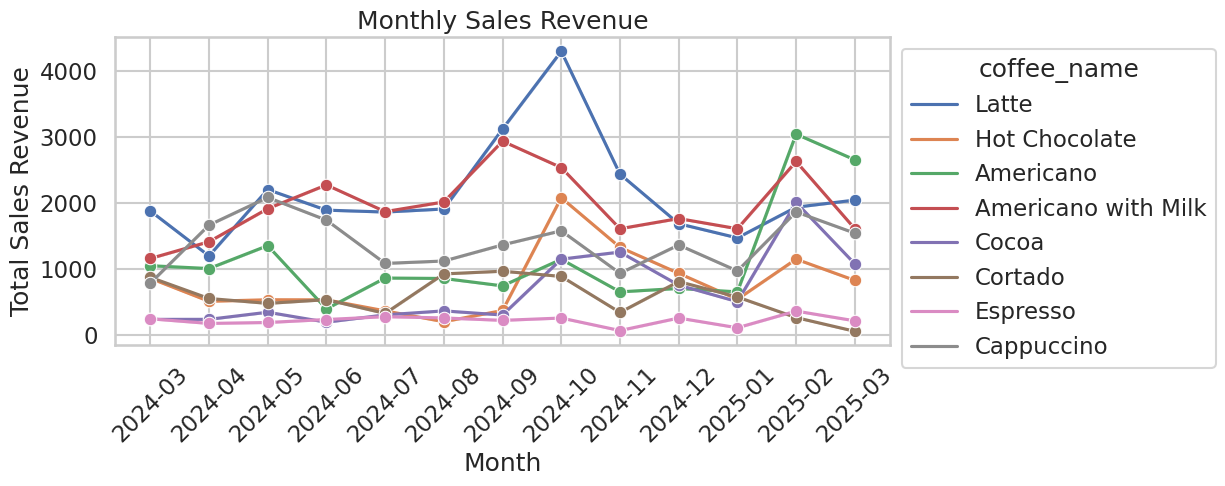

In [35]:
plt.figure(figsize=(10, 4))

sns.set(style="whitegrid")
sns.set_context("talk")

ax = sns.lineplot(data=df, x="month_str", y="monthly_sales", hue="coffee_name", marker="o")

# Grafik ayarları
plt.title("Monthly Sales Revenue")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue")
plt.xticks(rotation=45)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

## **Most Popular Coffee Types**

In [36]:
coffee_popularity = df['coffee_name'].value_counts()

In [37]:
coffee_popularity

coffee_name
Americano with Milk    824
Latte                  782
Americano              578
Cappuccino             501
Cortado                292
Hot Chocolate          282
Cocoa                  243
Espresso               134
Name: count, dtype: int64

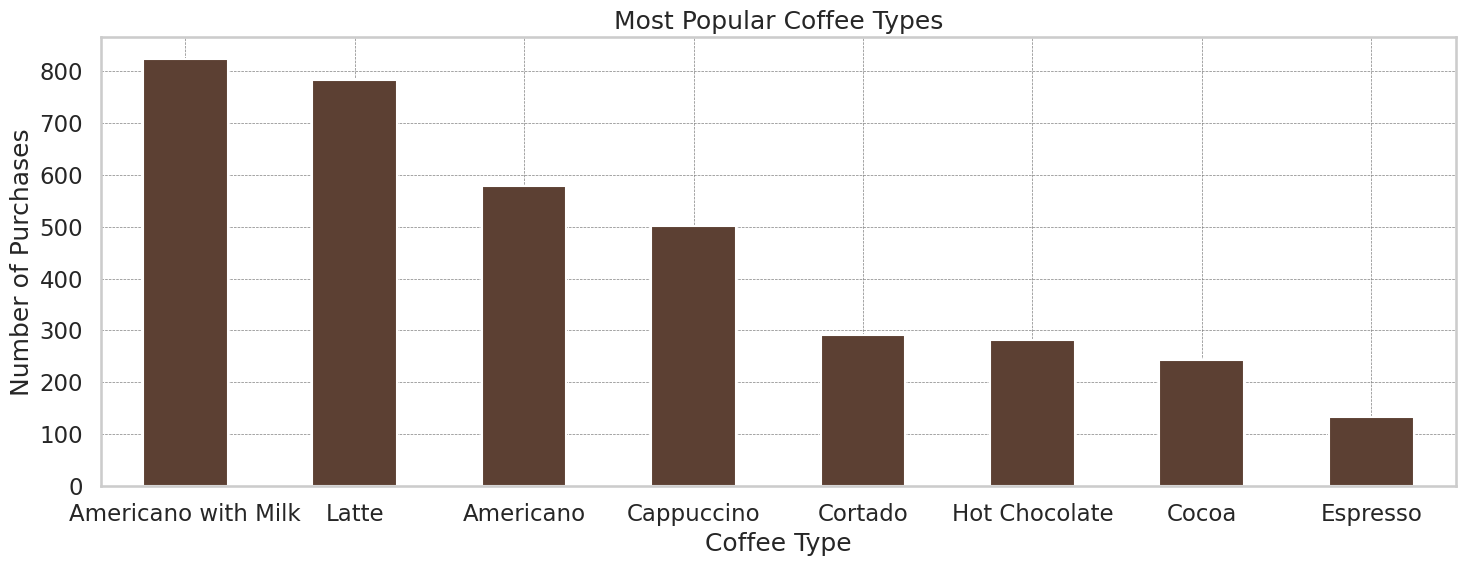

In [38]:
plt.figure(figsize=(15, 6))
coffee_popularity.plot(kind='bar', color="#5C4033")
plt.title('Most Popular Coffee Types')
plt.xlabel('Coffee Type')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()

## **Payment Method Distribution**

In [39]:
cash_or_card = df['cash_type'].value_counts()

In [40]:
cash_or_card

cash_type
card    3547
cash      89
Name: count, dtype: int64

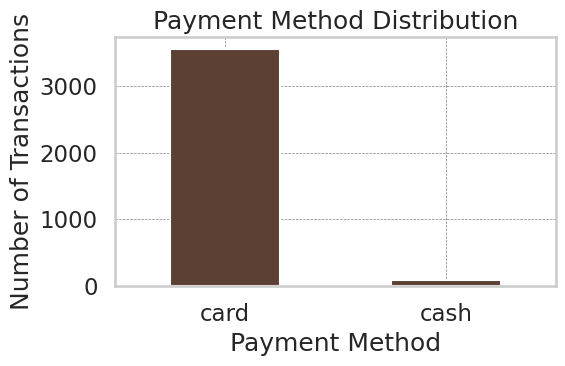

In [41]:
plt.figure(figsize=(6, 4))
cash_or_card.plot(kind='bar', color="#5C4033")
plt.title('Payment Method Distribution')
plt.xlabel('Payment Method')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()

## **Total Sales by Coffee Type**

In [42]:
sales_by_coffee_type = df.groupby('coffee_name')['money'].sum()

In [43]:
sales_by_coffee_type

coffee_name
Americano              15062.26
Americano with Milk    25269.12
Cappuccino             18034.14
Cocoa                   8678.16
Cortado                 7534.86
Espresso                2814.28
Hot Chocolate          10172.46
Latte                  27866.30
Name: money, dtype: float64

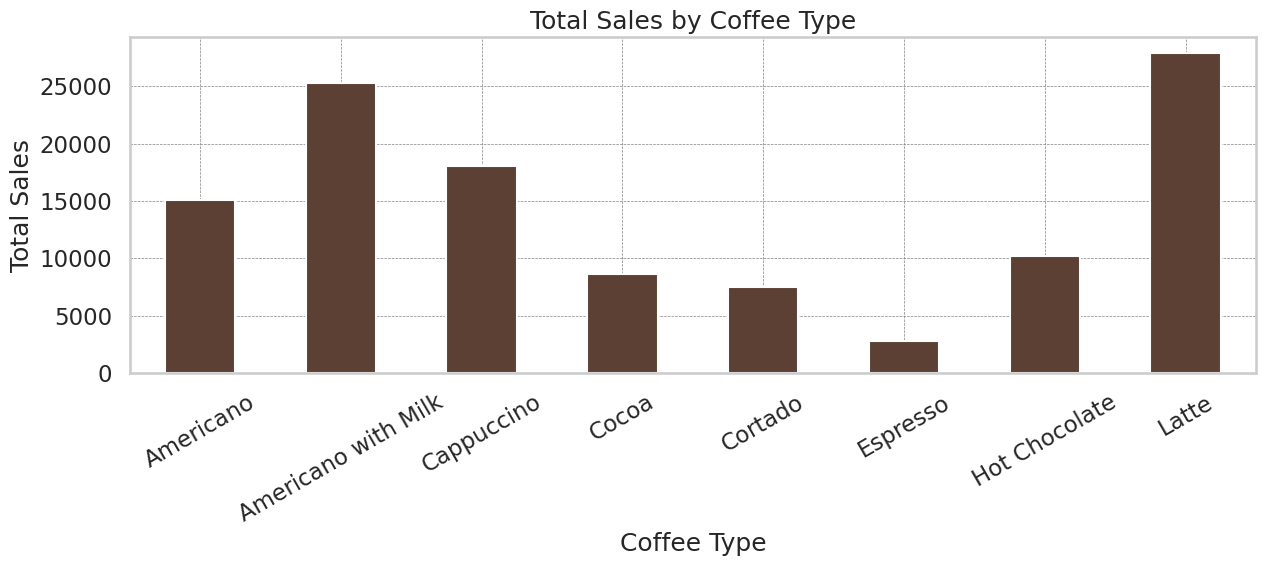

In [44]:
plt.figure(figsize=(13, 6))
sales_by_coffee_type.plot(kind='bar', color="#5C4033")
plt.title('Total Sales by Coffee Type')
plt.xlabel('Coffee Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()

# **Preprocessing**

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3636 non-null   object        
 1   datetime            3636 non-null   datetime64[ns]
 2   cash_type           3636 non-null   object        
 3   card                3547 non-null   object        
 4   money               3636 non-null   float64       
 5   coffee_name         3636 non-null   object        
 6   hour                3636 non-null   int32         
 7   hourly_total_sales  3636 non-null   float64       
 8   Day of Week         3636 non-null   object        
 9   month               3636 non-null   period[M]     
 10  day                 3636 non-null   object        
 11  daily_sales         3636 non-null   float64       
 12  monthly_sales       3636 non-null   float64       
 13  month_str           3636 non-null   object      

In [46]:
df['Day_of_Week'] = df['datetime'].dt.day_of_week
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day

In [47]:
df['minute'] = df['datetime'].dt.minute

In [48]:
df.head()

date                datetime cash_type                 card  money  \
0  2024-03-01 2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   38.7   
1  2024-03-01 2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   38.7   
2  2024-03-01 2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   38.7   
3  2024-03-01 2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   28.9   
4  2024-03-01 2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   38.7   

     coffee_name  hour  hourly_total_sales Day of Week    month         day  \
0          Latte    10             3003.20      Friday  2024-03  2024-03-01   
1  Hot Chocolate    12              329.68      Friday  2024-03  2024-03-01   
2  Hot Chocolate    12              329.68      Friday  2024-03  2024-03-01   
3      Americano    13             1228.46      Friday  2024-03  2024-03-01   
4          Latte    13             1450.48      Friday  2024-03  2024-03-01   

   daily_sales  monthly_sales month_str  Day_of_Week  Month  Day  minute  
0         77.4         1874.5   2024-03            4      3    1      15  
1        116.1          854.0   2024-03            4      3    1      19  
2        116.1          854.0   2024-03            4      3    1      20  
3         28.9         1044.8   2024-03            4      3    1      46  
4         77.4         1874.5   2024-03            4      3    1      48

***Label Encoding***

In [49]:
le = LabelEncoder()
df['coffee_name'] = le.fit_transform(df['coffee_name'])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3636 non-null   object        
 1   datetime            3636 non-null   datetime64[ns]
 2   cash_type           3636 non-null   object        
 3   card                3547 non-null   object        
 4   money               3636 non-null   float64       
 5   coffee_name         3636 non-null   int64         
 6   hour                3636 non-null   int32         
 7   hourly_total_sales  3636 non-null   float64       
 8   Day of Week         3636 non-null   object        
 9   month               3636 non-null   period[M]     
 10  day                 3636 non-null   object        
 11  daily_sales         3636 non-null   float64       
 12  monthly_sales       3636 non-null   float64       
 13  month_str           3636 non-null   object      

# **Models Building**

## **LGBM Regressor Model**

In [51]:
x = df[["money", "hour", "hourly_total_sales", "monthly_sales", "minute", "Day_of_Week", "Month", "Day" , "coffee_name"]]
y = df["daily_sales"]

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

In [53]:
lgbm = LGBMRegressor(n_estimators=1000, random_state=42, learning_rate=0.05)
lgbm_model = lgbm.fit(x_train, y_train)
lgbm_model.score(x_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 2908, number of used features: 9
[LightGBM] [Info] Start training from score 98.788899


0.6552573282813794

In [54]:
full_train = lgb.Dataset(x_train,y_train)
result_lgbm = pd.DataFrame()
result_lgbm['datetime'] = df['datetime'].values
result_lgbm['Predicted'] = np.concatenate([lgbm_model.predict(x_train),lgbm_model.predict(x_test)])
result_lgbm['Actual'] = np.concatenate([y_train, y_test])

In [55]:
result_lgbm

datetime   Predicted  Actual
0    2024-03-01 10:15:50.520   82.807254   71.52
1    2024-03-01 12:19:22.539   35.531553   30.86
2    2024-03-01 12:20:18.089  130.911974  139.60
3    2024-03-01 13:46:33.006   75.812593   65.64
4    2024-03-01 13:48:14.626   71.264829   71.52
...                      ...         ...     ...
3631 2025-03-23 10:34:54.894  260.427653  335.04
3632 2025-03-23 14:43:37.362  263.612808  279.20
3633 2025-03-23 14:44:16.864   53.964268   76.72
3634 2025-03-23 15:47:28.723  127.418861  123.44
3635 2025-03-23 18:11:38.635  109.099656  107.28

[3636 rows x 3 columns]

## **Random Forest Regressor Model**

In [56]:
rf = RandomForestRegressor(n_estimators=1000,random_state=42, n_jobs=-1)
rf_model = rf.fit(x_train, y_train)
rf_model.score(x_test, y_test)

0.7230979022146573

In [57]:
result_rf = pd.DataFrame()
result_rf['datetime'] = df['datetime'].values
result_rf['Predicted'] = np.concatenate([rf_model.predict(x_train), rf_model.predict(x_test)])
result_rf['Actual'] = np.concatenate([y_train, y_test])

In [58]:
result_rf

datetime  Predicted  Actual
0    2024-03-01 10:15:50.520   82.45258   71.52
1    2024-03-01 12:19:22.539   48.97524   30.86
2    2024-03-01 12:20:18.089  125.86330  139.60
3    2024-03-01 13:46:33.006   67.97506   65.64
4    2024-03-01 13:48:14.626   74.89646   71.52
...                      ...        ...     ...
3631 2025-03-23 10:34:54.894  305.51970  335.04
3632 2025-03-23 14:43:37.362  270.07442  279.20
3633 2025-03-23 14:44:16.864   59.87636   76.72
3634 2025-03-23 15:47:28.723   97.22408  123.44
3635 2025-03-23 18:11:38.635  105.36998  107.28

[3636 rows x 3 columns]

## **XGB Regressor Model**

In [59]:
boost = xgb.XGBRegressor()
xgb_model = boost.fit(x_train, y_train)
xgb_model.score(x_test, y_test)

0.6718130169796317

In [60]:
result_xgb = pd.DataFrame()
result_xgb['datetime'] = df['datetime'].values
result_xgb['Predicted'] = np.concatenate([xgb_model.predict(x_train), xgb_model.predict(x_test)])
result_xgb['Actual'] = np.concatenate([y_train, y_test])

In [61]:
result_xgb

datetime   Predicted  Actual
0    2024-03-01 10:15:50.520   86.680847   71.52
1    2024-03-01 12:19:22.539   33.177708   30.86
2    2024-03-01 12:20:18.089  128.785110  139.60
3    2024-03-01 13:46:33.006   69.020332   65.64
4    2024-03-01 13:48:14.626   69.830345   71.52
...                      ...         ...     ...
3631 2025-03-23 10:34:54.894  283.807861  335.04
3632 2025-03-23 14:43:37.362  257.042725  279.20
3633 2025-03-23 14:44:16.864   57.015091   76.72
3634 2025-03-23 15:47:28.723  158.448074  123.44
3635 2025-03-23 18:11:38.635  108.542885  107.28

[3636 rows x 3 columns]

## **Visualization of Actual and Predicted Values**

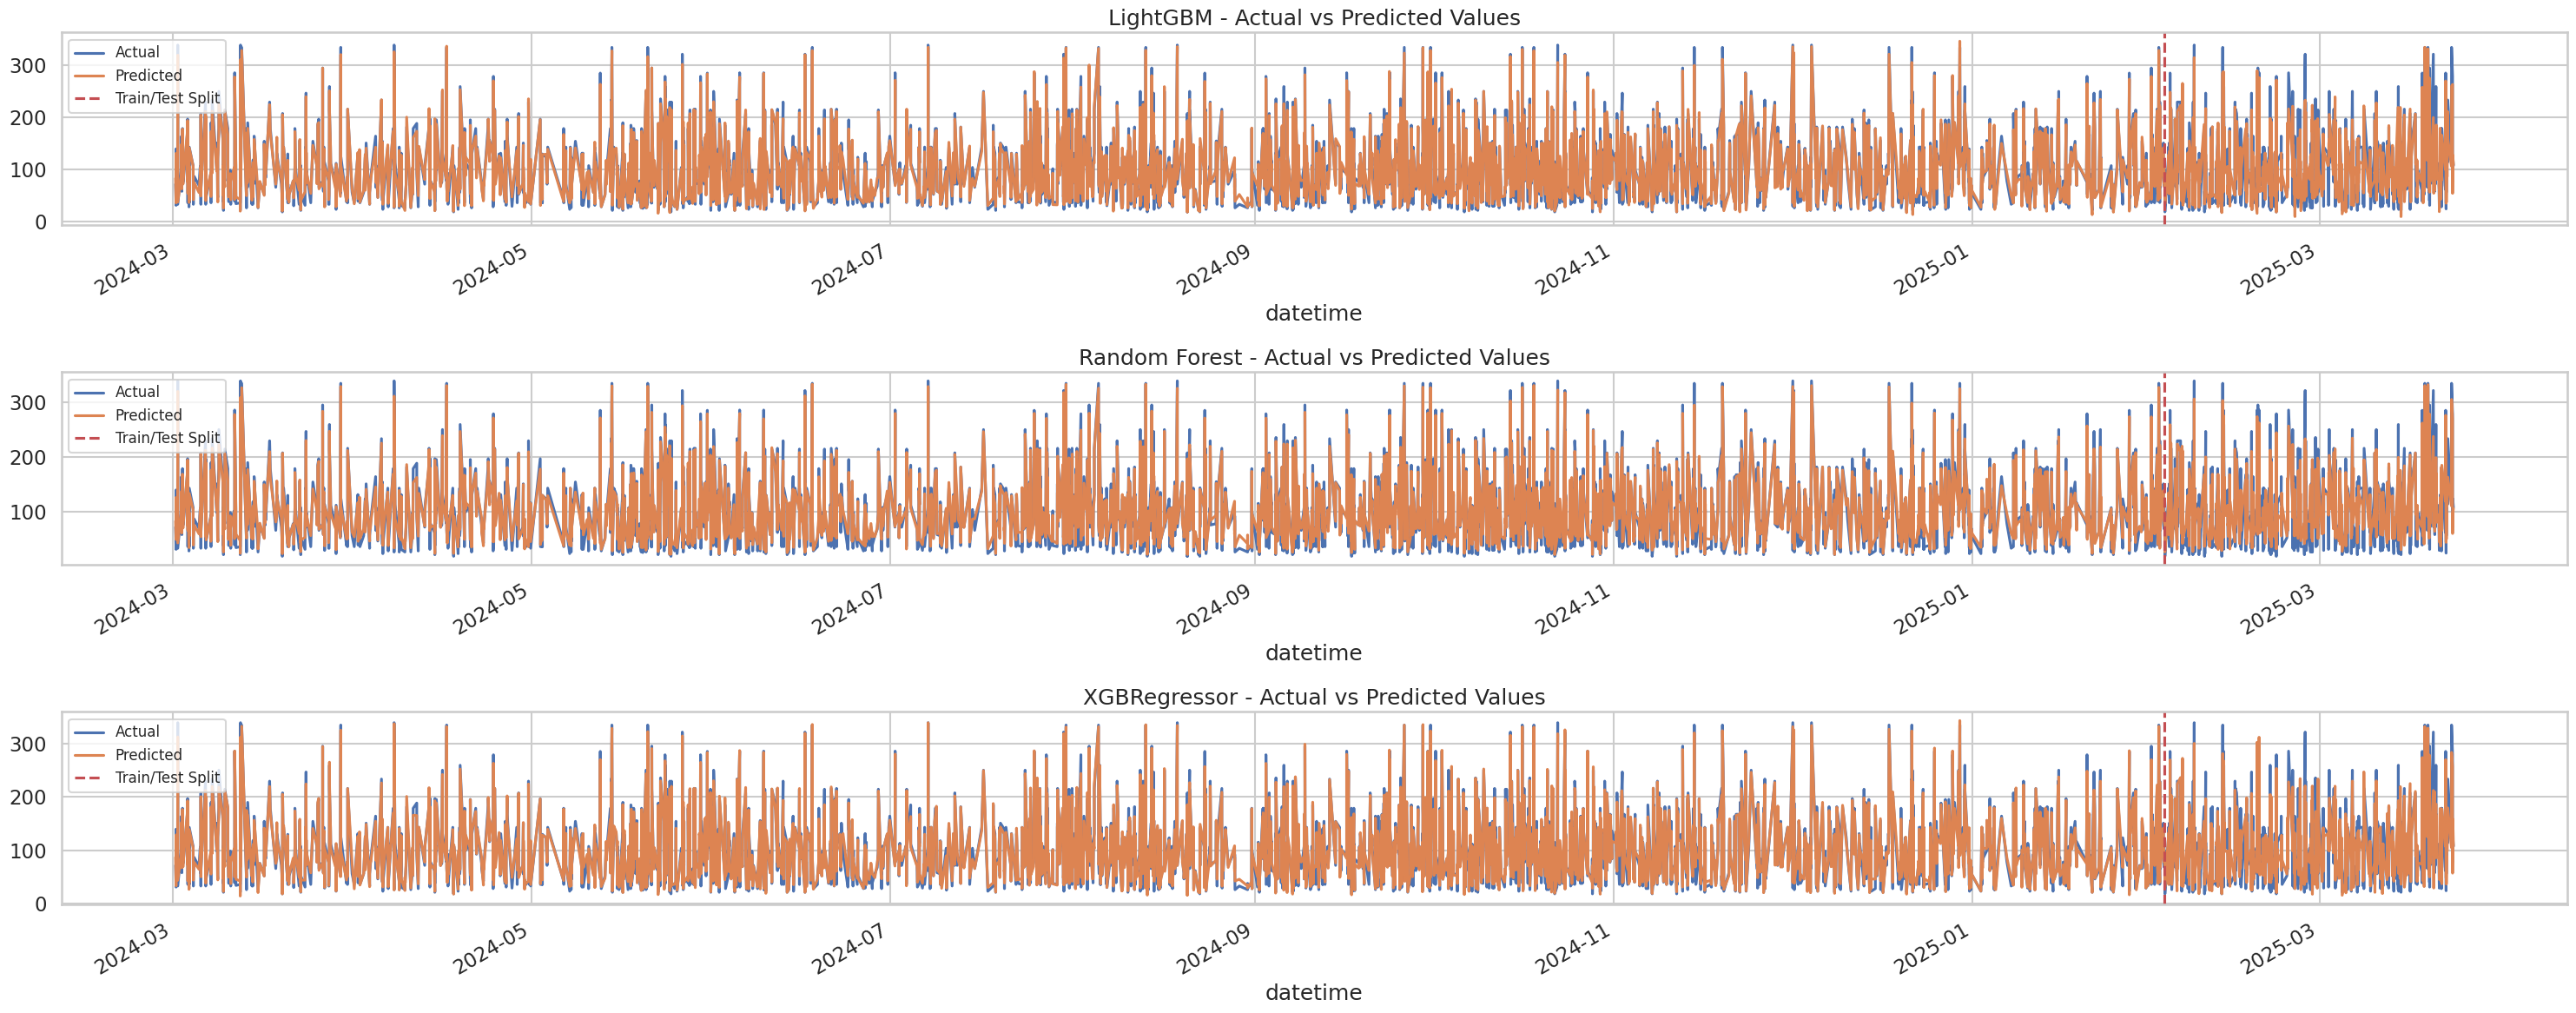


Performance Metrics of All Models:
        Model Dataset  R2 Score      RMSE       MAE     MAPE
     LightGBM   Train  0.972994 10.454239  7.748276 0.123043
Random Forest   Train  0.963128 12.215445  9.140216 0.159084
      XGBoost   Train  0.971881 10.667548  7.601389 0.119264
     LightGBM    Test  0.655257 36.812007 26.261303 0.420943
Random Forest    Test  0.723098 32.991731 23.924587 0.410221
      XGBoost    Test  0.671813 35.917215 26.271814 0.423088


In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 12))

result_lgbm.plot.line(x='datetime', y=['Actual', 'Predicted'], ax=ax1)
ax1.axvline(x=df.iloc[len(x_train)].datetime, color='r', linestyle='--', label='Train/Test Split')
ax1.legend(prop=dict(size=12))
ax1.set_title('LightGBM - Actual vs Predicted Values')

result_rf.plot.line(x='datetime', y=['Actual', 'Predicted'], ax=ax2)
ax2.axvline(x=df.iloc[len(x_train)].datetime, color='r', linestyle='--', label='Train/Test Split')
ax2.legend(prop=dict(size=12))
ax2.set_title('Random Forest - Actual vs Predicted Values')

result_xgb.plot.line(x='datetime', y=['Actual', 'Predicted'], ax=ax3)
ax3.axvline(x=df.iloc[len(x_train)].datetime, color='r', linestyle='--', label='Train/Test Split')
ax3.legend(prop=dict(size=12))
ax3.set_title('XGBRegressor - Actual vs Predicted Values')

plt.tight_layout()
plt.show()

def calculate_metrics(y_true, y_pred, model_name, dataset_type):
    metrics = {
        'Model': model_name,
        'Dataset': dataset_type,
        'R2 Score': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics

models = {
    'LightGBM': lgbm_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

all_metrics = []

for name, model in models.items():
    metrics = calculate_metrics(y_train, model.predict(x_train), name, 'Train')
    all_metrics.append(metrics)

for name, model in models.items():
    metrics = calculate_metrics(y_test, model.predict(x_test), name, 'Test')
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print("\nPerformance Metrics of All Models:")
print(metrics_df.to_string(index=False))

# **Daily Sales Forecast for Next 14 Days Using FBProphet**

In [63]:
df_prophet = df[['datetime', 'daily_sales']].rename(columns={'datetime':'ds', 'daily_sales':'y'})
df_prophet

ds       y
0    2024-03-01 10:15:50.520   77.40
1    2024-03-01 12:19:22.539  116.10
2    2024-03-01 12:20:18.089  116.10
3    2024-03-01 13:46:33.006   28.90
4    2024-03-01 13:48:14.626   77.40
...                      ...     ...
3631 2025-03-23 10:34:54.894   35.76
3632 2025-03-23 14:43:37.362   71.52
3633 2025-03-23 14:44:16.864   71.52
3634 2025-03-23 15:47:28.723   25.96
3635 2025-03-23 18:11:38.635   71.52

[3636 rows x 2 columns]

In [64]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = df['datetime']
prophet_df['y'] = df['daily_sales']

prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

In [65]:
prophet_df

ds       y
0    2024-03-01 10:15:50.520   77.40
1    2024-03-01 12:19:22.539  116.10
2    2024-03-01 12:20:18.089  116.10
3    2024-03-01 13:46:33.006   28.90
4    2024-03-01 13:48:14.626   77.40
...                      ...     ...
3631 2025-03-23 10:34:54.894   35.76
3632 2025-03-23 14:43:37.362   71.52
3633 2025-03-23 14:44:16.864   71.52
3634 2025-03-23 15:47:28.723   25.96
3635 2025-03-23 18:11:38.635   71.52

[3636 rows x 2 columns]

15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing


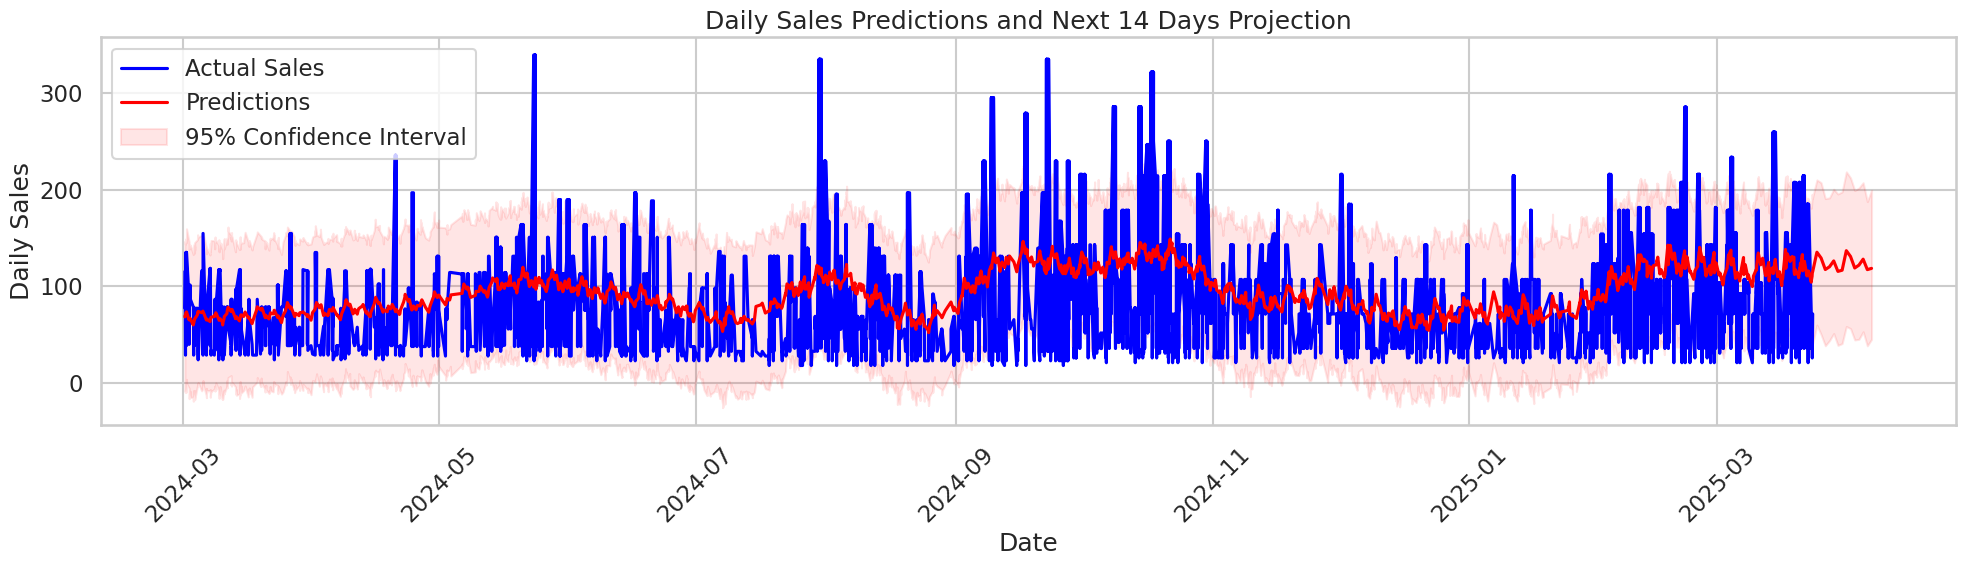

In [66]:
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)

prophet_model.fit(prophet_df)

future_dates = prophet_model.make_future_dataframe(periods=14, freq='D')
forecast = prophet_model.predict(future_dates)

fig, ax = plt.subplots(figsize=(20, 6))

plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual Sales', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Predictions', color='red', linestyle='-')

plt.fill_between(forecast['ds'],
                forecast['yhat_lower'],
                forecast['yhat_upper'],
                color='red',
                alpha=0.1,
                label='95% Confidence Interval')

plt.title('Daily Sales Predictions and Next 14 Days Projection')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
print("\nNext 14 Days Sales Predictions:")
future_predictions = forecast.tail(14)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
future_predictions.columns = ['Date', 'Predicted Sales', 'Lower Bound', 'Upper Bound']
print(future_predictions.round(2).to_string(index=False))


Next 14 Days Sales Predictions:
                   Date  Predicted Sales  Lower Bound  Upper Bound
2025-03-24 18:11:38.635           135.40        59.94       210.21
2025-03-25 18:11:38.635           129.36        50.12       207.26
2025-03-26 18:11:38.635           117.47        38.59       190.87
2025-03-27 18:11:38.635           120.33        43.92       191.63
2025-03-28 18:11:38.635           126.39        51.22       200.53
2025-03-29 18:11:38.635           115.53        39.01       195.65
2025-03-30 18:11:38.635           116.75        40.86       197.81
2025-03-31 18:11:38.635           137.00        58.54       218.55
2025-04-01 18:11:38.635           130.96        56.29       212.31
2025-04-02 18:11:38.635           119.05        44.62       199.18
2025-04-03 18:11:38.635           122.02        45.27       201.82
2025-04-04 18:11:38.635           128.21        53.08       207.31
2025-04-05 18:11:38.635           117.36        38.48       187.74
2025-04-06 18:11:38.635      


Component Analysis:


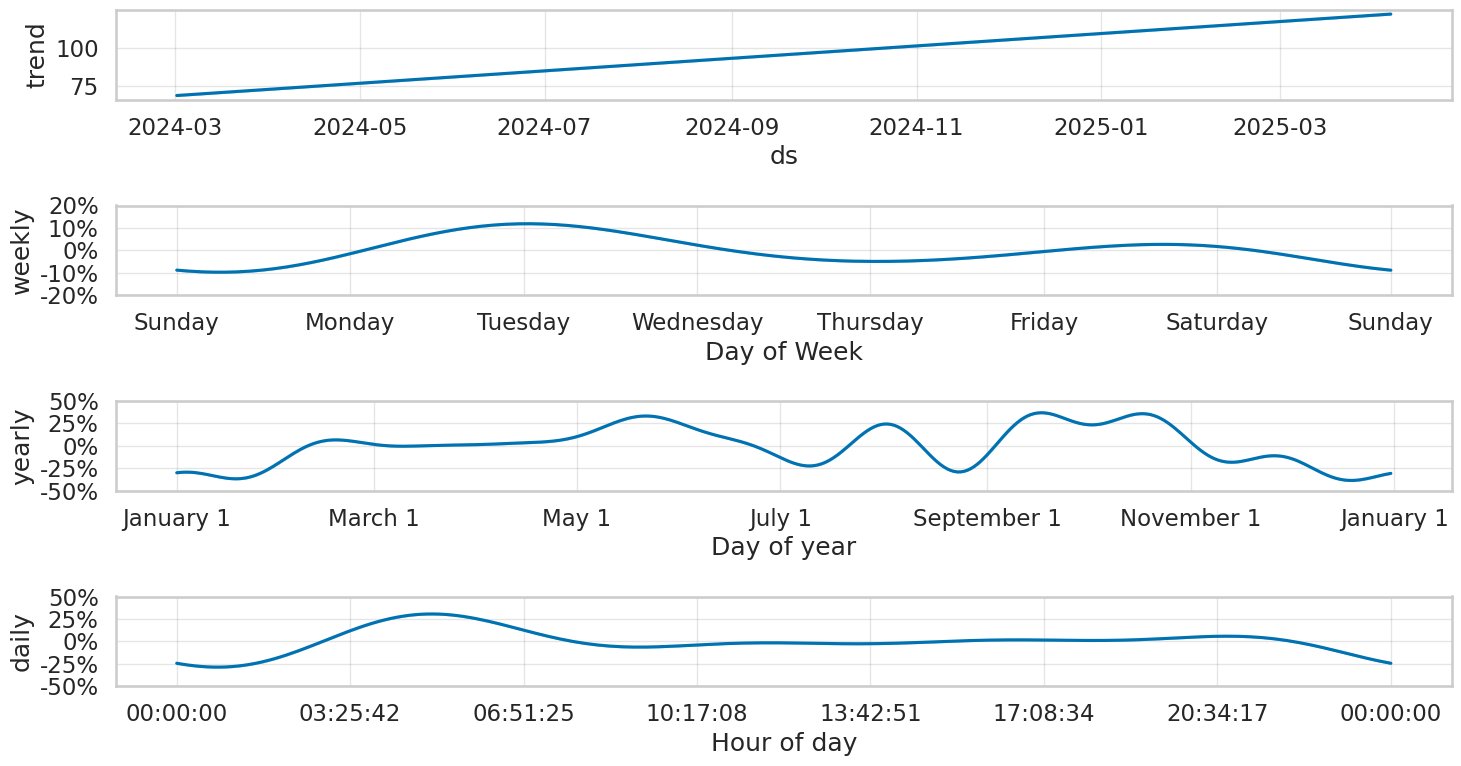

In [68]:
print("\nComponent Analysis:")
fig2 = prophet_model.plot_components(forecast, figsize=(15,8));
plt.show()

# **Correlation Heatmap**

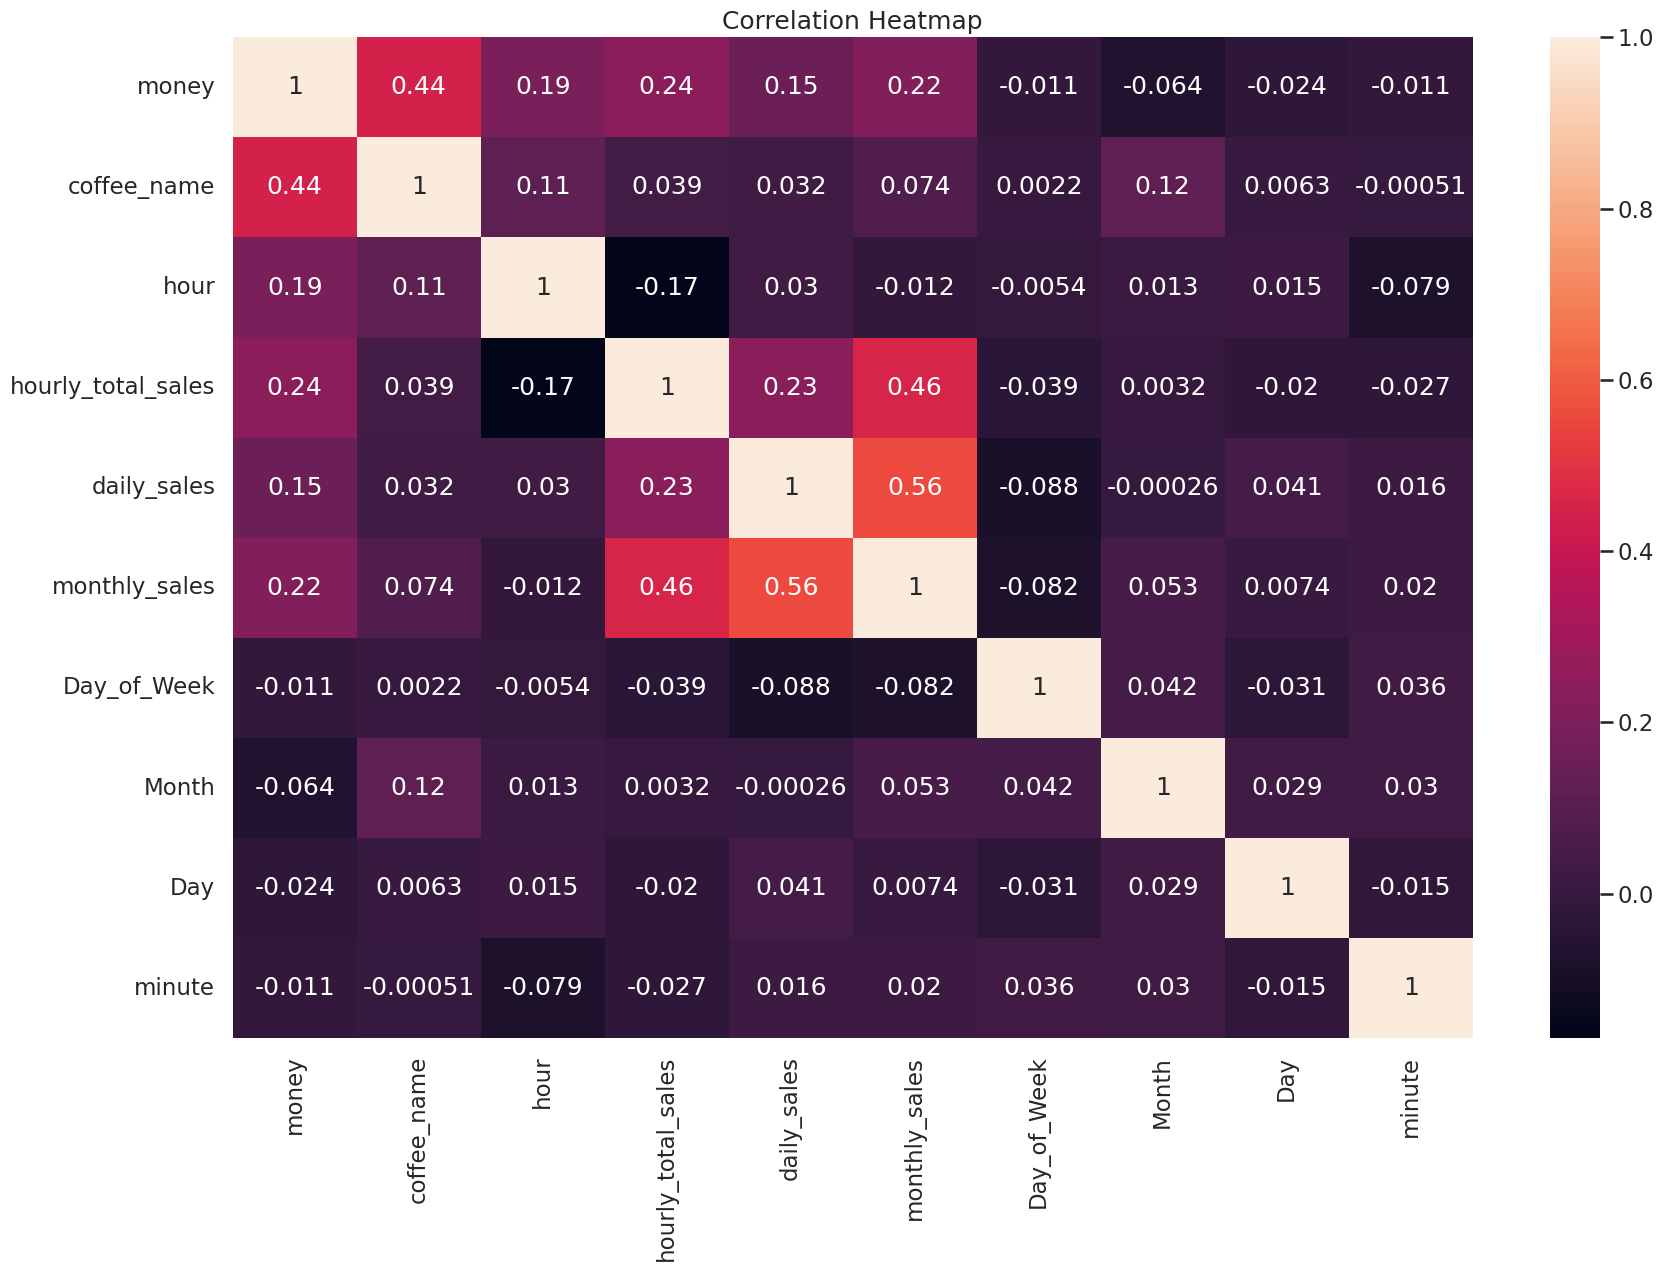

In [69]:
numerical_features = df.select_dtypes(include=['number', 'bool']).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(20, 13))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

# **Conclusion**

In this project, we analyzed coffee sales data to gain important insights and developed machine learning models to predict future sales. Through data preprocessing, exploratory data analysis (EDA), and modeling processes, we gained valuable information on coffee sales trends, popular products, and payment methods.

**Key Findings:**

* It was observed that sales increased on certain days and months.
* The most preferred coffee types and payment methods were determined.
* Regression models such as LightGBM, Random Forest, and XGBoost showed promising results in predicting daily sales.
* The Facebook Prophet model performed well in time series forecasts and produced sales forecasts for the next 14 days.